#### Manual Strategy Execution
I can use the LSEG refinitiv API for data collection

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import refinitiv.data as rd
from refinitiv.data.content import fundamental_and_reference
import os
from pprint import pprint
import seaborn as sns
from IPython.display import display
from warnings import filterwarnings
filterwarnings('ignore') 

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [2]:
print(np.__version__)
print(rd.__version__)

tmp_fields = ["TRDPRC_1", "OPEN_PRC", "HIGH_1", "LOW_1", "ACVOL_UNS"]
start = "2024-01-01"
end = "2024-12-31"
day_limit = 252

1.26.4
1.6.2


In [148]:
def universe_creation():
    tickers = ["AAPL.OQ", "MSFT.OQ", "GOOGL.OQ", "AMZN.OQ", "META.OQ", "TSLA.OQ", "NVDA.OQ", 
               "NVDA.OQ", "META.OQ", "JNJ", "TSLA.OQ", "AMD.OQ", "INTC.OQ", "QCOM.OQ", "ADBE.OQ", "NFLX.OQ", 
               "PYPL.OQ", "SBUX.OQ", "INTU.OQ", "TEAM.OQ", "BIDU.OQ", "EXPE.OQ"]
    return tickers

In [14]:
# api_key = os.environ("LSEG_API_KEY")
# rd.open_session(app_key=api_key)
rd.open_session()

<refinitiv.data.session.Definition object at 0x1b32aaf6de0 {name='workspace'}>

In [159]:
### Snapshots for Pricing
df = rd.get_data(
    universe=universe_creation(),
    fields=tmp_fields,
    parameters={"SDate": start, "EDate": end, "Frq": "D", "Curn":"USD"}
)

display(df.head(5))
print()

,Instrument,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
0,AAPL.OQ,244.6,241.26,245.41,241.15,12590393
1,MSFT.OQ,408.43,407.58,408.82,405.9,7150888
2,GOOGL.OQ,185.23,185.03,186.4,184.32,6701726
3,AMZN.OQ,228.68,229.11,229.79,227.24,7803914
4,META.OQ,736.67,727.1,740.87,725.95,3843042


##### LSEG .get_history() information - A FY has 252 trading days
<br>

| Column Name  | Description  |
|-------------|--------------|
| **TRDPRC_1** | Last traded price (closing price for that period). |
| **HIGH_1** | Highest price reached during the time period. |
| **LOW_1** | Lowest price reached during the time period. |
| **ACVOL_UNS** | Accumulated volume of trades (unscaled). |
| **OPEN_PRC** | Opening price of the asset for that period. |
| **BID** | Last recorded bid price (highest price a buyer is willing to pay). |
| **ASK** | Last recorded ask price (lowest price a seller is willing to accept). |
| **TRNOVR_UNS** | Turnover (traded value) in unscaled units. |
| **VWAP** | **Volume Weighted Average Price** - average trading price considering volume. |
| **BLKCOUNT** | Number of block trades (large transactions executed outside regular markets). |
| **BLKVOLUM** | Volume of shares traded in block trades. |
| **NUM_MOVES** | Number of price movements during the period. |
| **TRD_STATUS** | Trading status (e.g., open, closed, halted, auction, etc.). |
| **SALTIM** | Time of the last trade in seconds from midnight. |
| **CLS_AUCVOL** | Volume traded during the **closing auction**. |
| **OPN_AUCVOL** | Volume traded during the **opening auction**. |
| **VWAP_VOL** | Volume used to calculate VWAP (if different from ACVOL_UNS). |


In [ ]:
df_uni10 = rd.get_history(universe=universe_creation(), fields=tmp_fields, interval="1D", start = start, end = end).dropna()
display(df_uni10.head(5))

print(df_uni10.shape)

for nm in universe_creation():
    print('NAME:', nm)
    display(df_uni10[nm].head(2))

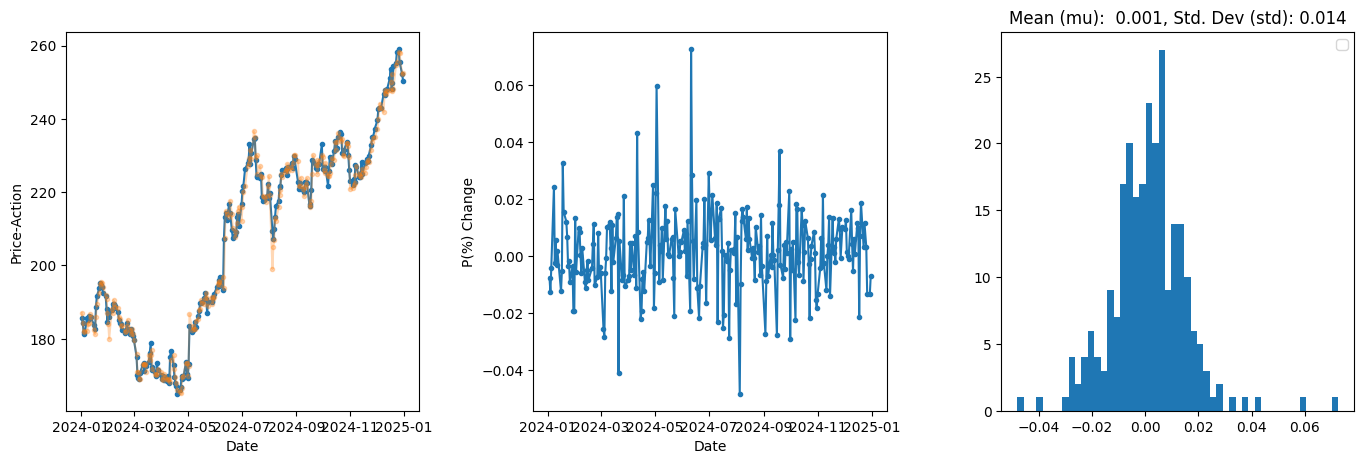

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

### We just do multi-indexing
axs[0].plot(df_uni10.index, df_uni10['AAPL.OQ']['TRDPRC_1'], marker = '.', label='close')
axs[0].plot(df_uni10.index, df_uni10['AAPL.OQ']['OPEN_PRC'], marker = '.', label='open', alpha=0.3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price-Action')

axs[1].plot(df_uni10.index, df_uni10['AAPL.OQ']['TRDPRC_1'].pct_change(), marker = '.', label='close')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('P(%) Change')

axs[2].hist(df_uni10['AAPL.OQ']['TRDPRC_1'].pct_change(), bins = 50)
_mu = df_uni10['AAPL.OQ']['TRDPRC_1'].pct_change().mean()
_std = df_uni10['AAPL.OQ']['TRDPRC_1'].pct_change().std()
axs[2].set_title(f'Mean (mu):  {_mu:.3f}, Std. Dev (std): {_std:.3f}')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [158]:
universe_creation()
print('LEN: ', len(universe_creation()))

LEN:  22


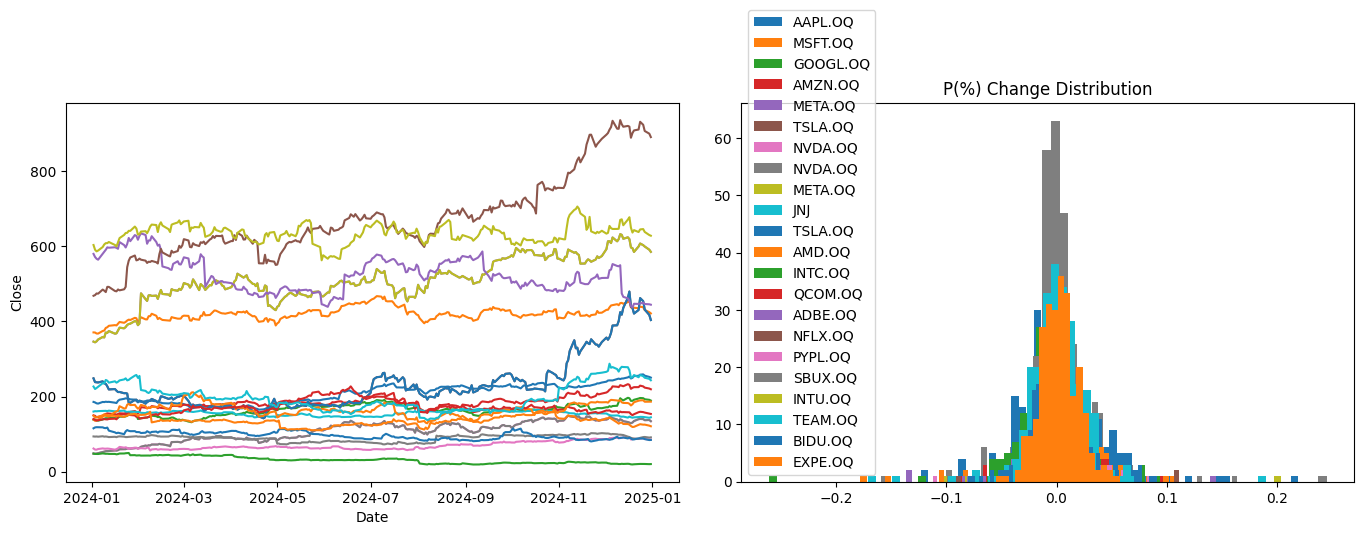

In [154]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

### We just do multi-indexing
for nm in universe_creation():
    axs[0].plot(df_uni10.index, df_uni10[nm]['TRDPRC_1'], label = nm)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Close')

plt.legend()

for nm in universe_creation():

    pct_change_clean = df_uni10[nm]['TRDPRC_1'].pct_change().dropna()

    if pct_change_clean.empty:
        print(f"Skipping {nm} due to no valid percentage change data.")
        continue
    
    axs[1].hist(pct_change_clean, bins = 50, label = nm)
    axs[1].set_title(f'P(%) Change Distribution')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [155]:
fundamental_df = rd.get_data(
    universe=universe_creation(),
    fields=["TR.Revenue.date", "TR.Revenue", "TR.GrossProfit", "TR.MktCap", "TR.BasicWeightedAvgShares"],
    parameters={
        "SDate": start,
        "EDate": end, # Full fiscal year
        "FRQ": "D", # Fiscal Year frequency (more standard than "A")
        "Curn": "USD" # Currency normalization
    }
)

display(fundamental_df.head(5))
print(fundamental_df.shape)
print(fundamental_df.columns)

## creates multi-index based on column indexing
fundamental_df = fundamental_df.set_index(['Instrument', 'Date'])

display(fundamental_df.head(5))
print(fundamental_df.shape)

display(fundamental_df.loc['AAPL.OQ'].head(5))

,Instrument,Date,Revenue,Gross Profit,Basic Weighted Average Shares
0,AAPL.OQ,2023-09-30,383285000000.0,169148000000.0,15744231000
1,AAPL.OQ,2023-09-30,383285000000.0,169148000000.0,15744231000
2,AAPL.OQ,2023-09-30,383285000000.0,169148000000.0,15744231000
3,AAPL.OQ,2023-09-30,383285000000.0,169148000000.0,15744231000
4,AAPL.OQ,2023-09-30,383285000000.0,169148000000.0,15744231000


(4788, 5)
Index(['Instrument', 'Date', 'Revenue', 'Gross Profit',
       'Basic Weighted Average Shares'],
      dtype='object')


Revenue    Gross Profit  \
Instrument Date                                         
AAPL.OQ    2023-09-30  383285000000.0  169148000000.0   
           2023-09-30  383285000000.0  169148000000.0   
           2023-09-30  383285000000.0  169148000000.0   
           2023-09-30  383285000000.0  169148000000.0   
           2023-09-30  383285000000.0  169148000000.0   

                       Basic Weighted Average Shares  
Instrument Date                                       
AAPL.OQ    2023-09-30                    15744231000  
           2023-09-30                    15744231000  
           2023-09-30                    15744231000  
           2023-09-30                    15744231000  
           2023-09-30                    15744231000

(4788, 3)


,Revenue,Gross Profit,Basic Weighted Average Shares
Date,,,
2023-09-30,383285000000.0,169148000000.0,15744231000
2023-09-30,383285000000.0,169148000000.0,15744231000
2023-09-30,383285000000.0,169148000000.0,15744231000
2023-09-30,383285000000.0,169148000000.0,15744231000
2023-09-30,383285000000.0,169148000000.0,15744231000


['2023-09-30T00:00:00.000000000' '2024-09-28T00:00:00.000000000']


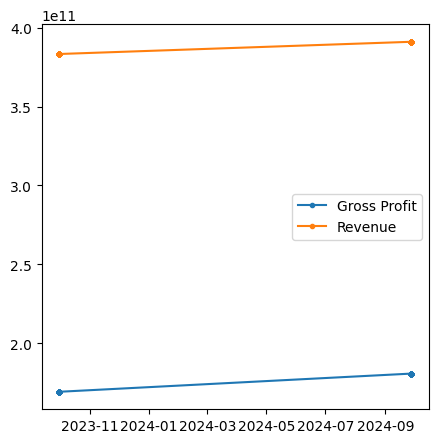

In [156]:
fig = plt.figure(figsize=(5, 5))

print(np.unique(np.array(fundamental_df.loc['AAPL.OQ'].index))) ### Maybe thats the time when gross-profit and revenue gets published (but shouldn't that be q1-4) - annual report for 1FY not quartly 
plt.plot(fundamental_df.loc['AAPL.OQ'].index, fundamental_df.loc['AAPL.OQ']['Gross Profit'], marker = '.', label = 'Gross Profit')
plt.plot(fundamental_df.loc['AAPL.OQ'].index, fundamental_df.loc['AAPL.OQ']['Revenue'], marker = '.', label = 'Revenue')

plt.legend()
plt.show()

In [110]:
rd.close_session()

In [157]:
val_dict = {}
val_arr = []

for nm in universe_creation():
    pct = np.array(df_uni10[nm]['TRDPRC_1'].pct_change().fillna(0)).tolist()
    close = np.array(df_uni10[nm]['TRDPRC_1']).tolist()
    vol = np.array(df_uni10[nm]['ACVOL_UNS']).tolist()
    revenue = np.array(fundamental_df.loc[nm]['Revenue']) 
    gross_profit = np.array(fundamental_df.loc[nm]['Gross Profit'])
    was = np.array(fundamental_df.loc[nm]['Basic Weighted Average Shares'])

    val_arr.append([close, pct, vol, revenue, gross_profit, was])
    val_dict[nm] = [close, pct, vol, revenue, gross_profit, was]

val_arr = np.array(val_arr).reshape(len(universe_creation()), -1)
print(val_arr.shape)

(22, 1512)


##### PCA + Clustering
A fixed n_components shows systemic risk/volatility which shows fewer components moving the market while unsystemic risk shows diversification and more singular stock trading oppurtunity  

In [177]:
variance_perc = 0.75
cluster_distance_threshold = None
cluster_percentile = 20

(22, 3)


<Figure size 500x500 with 0 Axes>

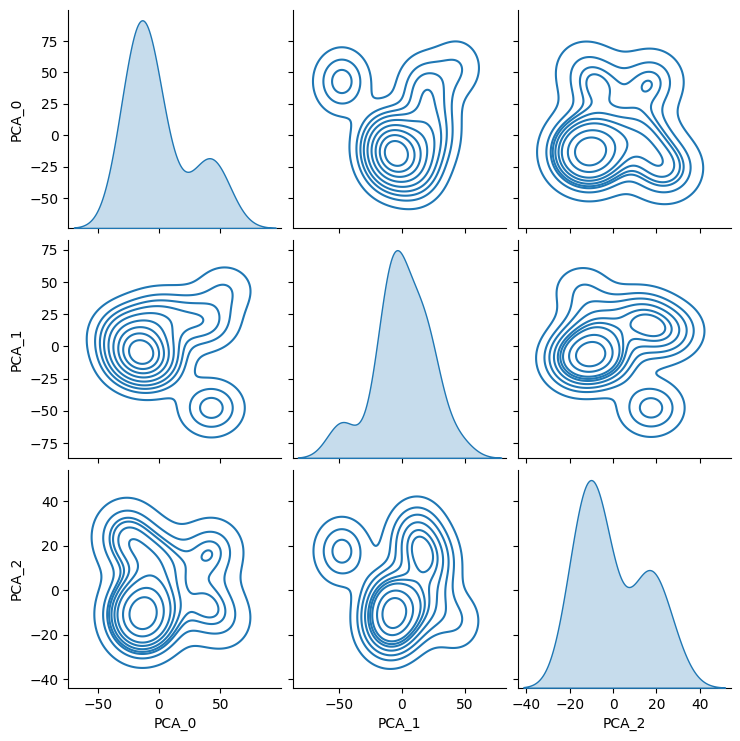

In [178]:
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(val_arr)

pca = PCA(n_components=variance_perc)
pca_arr = pca.fit_transform(scaled_arr)

print(pca_arr.shape)

fig = plt.figure(figsize=(5, 5))

sns.pairplot(pd.DataFrame(pca_arr, columns=['PCA_' + str(i) for i in range(pca_arr.shape[-1])]), kind='kde')
plt.show()

In [179]:
pairwise_distances = np.linalg.norm(pca_arr[:, np.newaxis] - pca_arr, axis=2)
upper_tri_indices = np.triu_indices_from(pairwise_distances, k=1)
distances = pairwise_distances[upper_tri_indices]

min_distance = distances.min()
max_distance = distances.max()

if min_distance < 0:
    min_distance = 0.0
if max_distance < 0:
    max_distance = 1.0

cluster_distance_threshold = np.percentile(distances, cluster_percentile)

# Validate cluster_distance_threshold
if not np.isfinite(cluster_distance_threshold) or cluster_distance_threshold < 0:
    cluster_distance_threshold = 1.0  # Default positive value        

In [180]:
aggl_cluster = AgglomerativeClustering(
        linkage='average',
        n_clusters=None,
        distance_threshold=cluster_distance_threshold
)

cluster_labels = aggl_cluster.fit_predict(pca_arr)

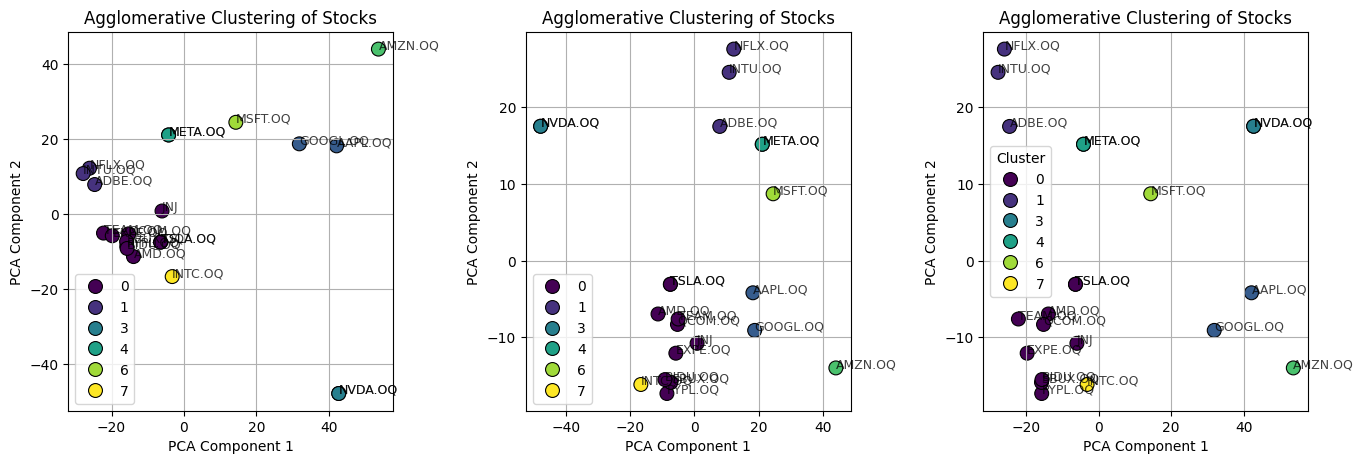

In [181]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 1], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[0])
sns.scatterplot(x=pca_arr[:, 1], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[1])
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[2])

for i, stock in enumerate(universe_creation()):
    axs[0].annotate(stock, (pca_arr[i, 0], pca_arr[i, 1]), fontsize=9, alpha=0.75)

for i, stock in enumerate(universe_creation()):
    axs[1].annotate(stock, (pca_arr[i, 1], pca_arr[i, 2]), fontsize=9, alpha=0.75)

for i, stock in enumerate(universe_creation()):
    axs[2].annotate(stock, (pca_arr[i, 0], pca_arr[i, 2]), fontsize=9, alpha=0.75)


axs[0].set_title("Agglomerative Clustering of Stocks")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

axs[1].set_title("Agglomerative Clustering of Stocks")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

axs[2].set_title("Agglomerative Clustering of Stocks")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.legend(title="Cluster")
plt.tight_layout(pad=2)
plt.show()

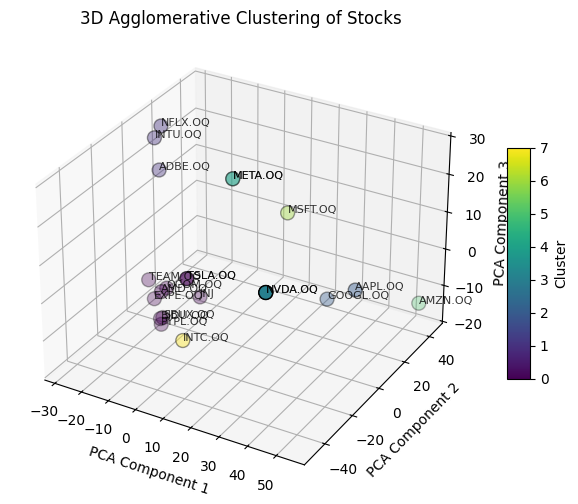

In [184]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_arr[:, 0], pca_arr[:, 1], pca_arr[:, 2], 
                c=cluster_labels, cmap="viridis", s=100, edgecolor="black")

for i, stock in enumerate(universe_creation()):
    ax.text(pca_arr[i, 0], pca_arr[i, 1], pca_arr[i, 2], stock, fontsize=8, alpha=0.8)

ax.set_title("3D Agglomerative Clustering of Stocks")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster")

plt.show()

#### Co-Integration Selection + Volatility Weighted Portofolio Creation  

My first goal should be to complete the basic pipeline before tuning the actual algorithm. This includes an end-to-end implementation, from stock selection to sending hedged portfolios to the QRT FTP servers for the daily report.

### Data Presence Matrix OR Stock Presence Matrix (in Universe)